# 1. Introduction

The first notebook downloads all necessary data and metadata for the tutorial. A similar approach may be reproduced to analyze any seismic data set of your choice.

Note that this tutorial uses `pathlib.Path` objects to handle conveniently file paths. For more information you read the [official pathlib documentation](https://docs.python.org/3/library/pathlib.html). Also note that the velocity model is stored as an `hdf5` file, which is a binary file format that we manipulate with the `h5py` library. If you are not familiar with `hdf5` files, you can read the [h5py documentation](https://docs.h5py.org/en/stable/). In general, the velocity model may be written in any format.

In [2]:
from pathlib import Path

import h5py as h5
import numpy as np
import obspy

import covseisnet as csn

## Download the seimograms

This first cell downloads the continuous seismograms from the RESIF datacenter. The dataset takes about 60MB. The function is written in the `covseisnet.data` module and internally calls the `covseisnet.data.download_seismic_dataset` function. Check out its documentation for more information.

In [3]:
# Set the download path for the data
filepath = Path("data/undervolc.mseed")
filepath.parent.mkdir(exist_ok=True)

# Download the data
csn.data.download_undervolc_data(filepath_destination=filepath)

# Check stream
stream = csn.read(filepath)

Data saved to data/undervolc.mseed


## Download data inventory

Most notebooks will use metadata stored in the inventory of the RESIF datacenter. This inventory is an XML file that can be obtained with obspy. With `covseisnet`, the inventory can be downloaded with `covseisnet.NetworkStream`'s method called `download_inventory`. The inventory is then saved in the `data` directory.

In [6]:
# Download the inventory
inventory = stream.download_inventory(datacenter="RESIF")

# Write the inventory to a file
inventory.write("data/undervolc.xml", "stationxml")

The `inventory` object is an ObsPy object that comes with several useful methods, including a plotting method. If your Python environment includes `cartopy`, `inventory.plot` uses it to draw the map.

Text(0.5, 1.0, 'Map of seismic stations near Piton de la Fournaise')

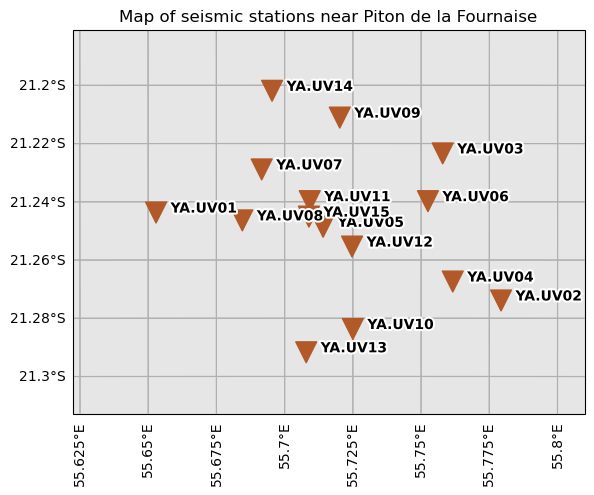

In [4]:
# Read the inventory
inventory = obspy.read_inventory("data/undervolc.xml")

# Plot the inventory
fig = inventory.plot(projection="local", show=False)

# Extract axes for custom labelling
ax = fig.axes[0]
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.right_labels = False
ax.set_title("Map of seismic stations near Piton de la Fournaise")

## Read the velocity model of the Piton de la Fournaise volcano

We use the 3D velocity model of the Piton de la Fournaise volcano (Mordret et al. 2014), available in the supplementary material. The model has to be prescribed onto a regular 3D grid in longitude/latitude/depth. The model can be displayed with the `grid3d` function of the `covseisnet.plot` module. 

> Mordret, A., Rivet, D., Landès, M., & Shapiro, N. M. (2015). Three‐dimensional shear velocity anisotropic model of Piton de la Fournaise Volcano (La Réunion Island) from ambient seismic noise. Journal of Geophysical Research: Solid Earth, 120(1), 406-427.

yes


Text(0.5, 0.98, 'S-wave velocity model in the original grid')

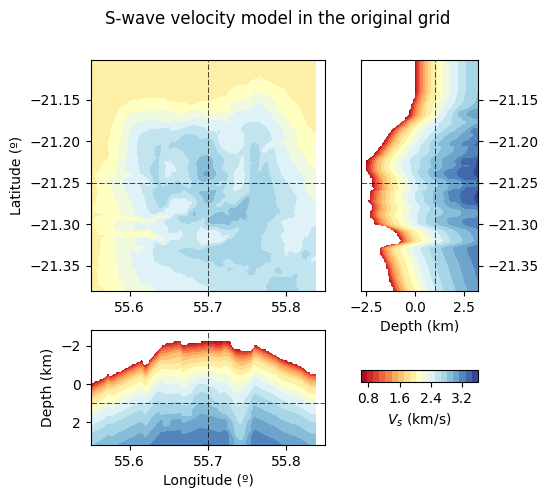

In [11]:
# Read the model
filepath_model = Path("data/velocity_model_Mordret2025.h5").absolute()
velocity_field_name = "Vs"

# The h5 file contains the velocity model in a 3D grid with the following
# dimensions in order: longitude, latitude, depth. The depth and velocity are
# in meters and meters per second, respectively.
with h5.File(filepath_model, "r") as velocity_model:

    # Coordinates
    lon = np.array(velocity_model["longitude"])
    lat = np.array(velocity_model["latitude"])
    depth = np.array(velocity_model["depth"]) * 1e-3

    # Velocity
    velocity = np.array(velocity_model[velocity_field_name])
    velocity /= 1e3

# Get extent
model = csn.velocity.model_from_grid(lon, lat, depth, velocity)

# Plot the grid
fig, axes = csn.plot.grid3d(model, profile_coordinates=[55.7, -21.25, 1], cmap="RdYlBu", label="$V_s$ (km/s)")
fig.suptitle("S-wave velocity model in the original grid")

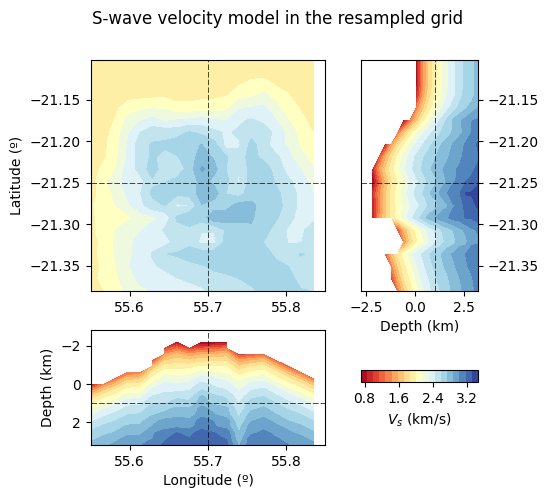

In [14]:
model_i = model.resample((20, 20, 20))

fig, ax = csn.plot.grid3d(
    model_i,
    profile_coordinates=[55.7, -21.25, 1],
    cmap="RdYlBu",
    label="$V_s$ (km/s)",
)

fig.suptitle("S-wave velocity model in the resampled grid")

csn.plot.plt.show()

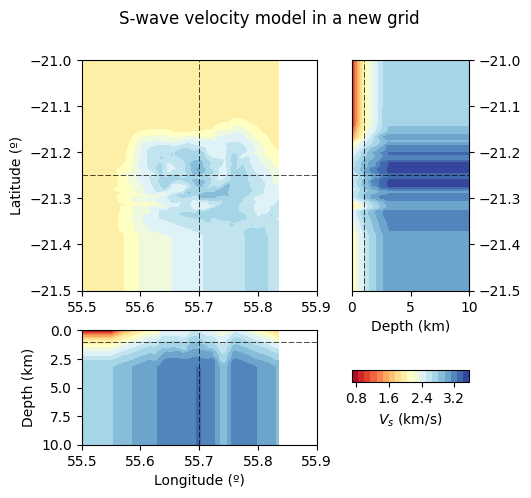

In [16]:
lons = np.linspace(55.5, 55.9, 100)
lats = np.linspace(-21.5, -21, 100)
depths = np.linspace(0, 10, 100)

model_i = model.interpolate(lons, lats, depths)

fig, ax = csn.plot.grid3d(
    model_i,
    profile_coordinates=[55.7, -21.25, 1],
    cmap="RdYlBu",
    label="$V_s$ (km/s)",
)
fig.suptitle("S-wave velocity model in a new grid")
csn.plot.plt.show()